In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split, KFold, GridSearchCV, ParameterGrid, StratifiedKFold
from sklearn.metrics import mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.ensemble import GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image
import pydotplus
import time as time
import itertools as it

import statsmodels.formula.api as sm
from collections import OrderedDict
import pickle

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

## Note: Summary of our (base) model performances are at the bottom of this file. {-}

In summary, we found that that more complex ensemble methods (in particular, bagged decision trees & random forests) performed best our of our initial base models, which is not surprising. 

In the future, we will continue to explore more complex models discussed in class this quarter, as well as tune hyperparameters more closely for our base models that we've found have worked well so far (namely, bagged decision trees & random forests).

Also, as a refresher, we've also attached a PDF of our project proposal if the grader would like to look at this as well to jog their memory. In short, we're predicting a binary classification response: that is, satisfied (1) vs. neutral/dissatisfied (0) airline customers. See [here](https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction) for a link to the dataset as well, if desired.

## Data Prep {-}

In [3]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [4]:
train = train.rename(columns={"On-board service": "Onboard_service"})
test = test.rename(columns={"On-board service": "Onboard_service"})

In [5]:
#encode satisfaciton column values to 0 for dissatisfied and 1 for satisfied
train["satisfaction"] = train["satisfaction"].replace(['neutral or dissatisfied'], '0')
train["satisfaction"] = train["satisfaction"].replace(['satisfied'], '1')

test["satisfaction"] = test["satisfaction"].replace(['neutral or dissatisfied'], '0')
test["satisfaction"] = test["satisfaction"].replace(['satisfied'], '1')

#make dummy for categorical variables
train_dummies = pd.get_dummies(train[["Gender", "Customer Type", "Type of Travel", "Class"]])
train = pd.concat([train, train_dummies], axis=1)
train = train.drop(columns=["Gender", "Customer Type", "Type of Travel", "Class"])

test_dummies = pd.get_dummies(test[["Gender", "Customer Type", "Type of Travel", "Class"]])
test = pd.concat([test, test_dummies], axis=1)
test = test.drop(columns=["Gender", "Customer Type", "Type of Travel", "Class"])

#drop na
train = train.dropna()
test = test.dropna()

train = train.drop(columns=["Unnamed: 0", "id"])
test = test.drop(columns=["Unnamed: 0", "id"])

In [6]:
train.columns = train.columns.str.replace(' ', '_')
train.columns = train.columns.str.replace('/', '_')

test.columns = test.columns.str.replace(' ', '_')
test.columns = test.columns.str.replace('/', '_')

test.columns = test.columns.str.replace('-', '_')
test.columns = test.columns.str.replace('-', '_')

In [7]:
train["satisfaction"] = train["satisfaction"].astype(int)
test["satisfaction"] = test["satisfaction"].astype(int)

In [8]:
X = train.drop(columns=["satisfaction"])
y = train["satisfaction"]

Xtest = test.drop(columns=["satisfaction"])
ytest = test["satisfaction"]

## Linear Models (303-2 Models) {-}

In [9]:
#Function to compute confusion matrix and prediction accuracy on test/train data
def confusion_matrix_data(data,actual_values,model,cutoff=0.5):
    #Predict the values using the Logit model
    pred_values = model.predict_proba(data)[:,1]
    # Specify the bins
    bins=np.array([0,cutoff,1])
    #Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
    # Calculate the accuracy
    accuracy = 100*(cm[0,0]+cm[1,1])/cm.sum()
    fnr = 100*(cm[1,0])/(cm[1,0]+cm[1,1])
    precision = 100*(cm[1,1])/(cm[0,1]+cm[1,1])
    fpr = 100*(cm[0,1])/(cm[0,0]+cm[0,1])
    tpr = 100*(cm[1,1])/(cm[1,0]+cm[1,1])
    print("Accuracy = ", accuracy)
    print("Precision = ", precision)
    print("FNR = ", fnr)
    print("FPR = ", fpr)
    print("TPR or Recall = ", tpr)
    print("Confusion matrix = \n", cm_df)
    return (" ")

### Forward Selection {-}

In [10]:
#Function to compute confusion matrix and prediction accuracy on test data
def confusion_matrix(data, actual_values, model, cutoff = 0.5):
    #Predict the values using the Logit model
    pred_values = model.predict(data)
    # Specify the bins
    bins = np.array([0, cutoff, 1])
    # Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins = bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index = {0: 'Actual 0', 1: 'Actual 1'})
    # Calculate the accuracy
    accuracy = 100 * (cm[0, 0] + cm[1, 1]) / cm.sum()
    # Return the confusion matrix and the accuracy
    return cm_df, accuracy

In [11]:
#Function to develop a model based on all predictors in predictor_subset
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    model = sm.logit('satisfaction ~ ' + '+'.join(predictor_subset), data = train).fit(disp=0)
    Accuracy = confusion_matrix(train, train.satisfaction, model)[1]
    return {"model": model, "Accuracy": Accuracy}

In [12]:
#Function to find the best predictor out of p-k predictors and add it to the model containing the k predictors
def forward(predictors):
    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    tic = time.time()
    results = []
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
        
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest Accuracy
    best_model = models.loc[models['Accuracy'].argmax()]
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1,"predictors in", (toc-tic), "seconds.")
    # Return the best model, along with some other useful information about the model
    return best_model

In [13]:
def forward_selection():
    models_best = pd.DataFrame(columns = ["Accuracy", "model"])
    tic = time.time()
    predictors = []
    for i in range(1, len(X.columns)+1):
        models_best.loc[i] = forward(predictors)
        predictors = list(models_best.loc[i]["model"].params.index[1:])
        # Extra handling for qualitative variables
        for i in range(len(predictors)):
            predictors[i] = predictors[i].split('[')[0]
        # Removing duplicates
        predictors = list(OrderedDict.fromkeys(predictors))
    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

In [27]:
def best_sub_plots(models_best):
    plt.figure(figsize = (20,15))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})
    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(3, 2, 1)
    # We will now plot a red dot to indicate the model with the largest training Accuracy statistic.
    plt.plot(models_best["Accuracy"])
    plt.plot(1 + models_best["Accuracy"].argmax(), models_best["Accuracy"].max(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('Training Accuracy')
    plt.text(1 + models_best["Accuracy"].argmax(), models_best["Accuracy"].max(), str(1 + models_best["Accuracy"].argmax()),
            verticalalignment='bottom', horizontalalignment='right')
    
    # We will now plot a red dot to indicate the model with the smallest training Precision statistic.
    models_best['Precision'] = models_best.apply(lambda row: precision(confusion_matrix(train, train.satisfaction, row[1])), axis=1)
    plt.subplot(3, 2, 2)
    plt.plot(models_best['Precision'])
    plt.plot(1 + models_best['Precision'].argmax(), models_best['Precision'].max(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('Training Precision')
    plt.text(1 + models_best['Precision'].argmax(), models_best['Precision'].max(), str(1 + models_best['Precision'].argmax()),
            verticalalignment='bottom', horizontalalignment='right')
    
    

In [25]:
models_best = forward_selection()

Processed  27 models on 1 predictors in 1.2451457977294922 seconds.
Processed  26 models on 2 predictors in 1.42549467086792 seconds.
Processed  25 models on 3 predictors in 1.7399632930755615 seconds.
Processed  24 models on 4 predictors in 1.8270490169525146 seconds.
Processed  23 models on 5 predictors in 4.105967283248901 seconds.
Processed  22 models on 6 predictors in 4.694643974304199 seconds.
Processed  21 models on 7 predictors in 4.664995908737183 seconds.
Processed  20 models on 8 predictors in 4.83539080619812 seconds.
Processed  19 models on 9 predictors in 4.026109933853149 seconds.
Processed  18 models on 10 predictors in 4.461400032043457 seconds.
Processed  17 models on 11 predictors in 5.073512077331543 seconds.
Processed  16 models on 12 predictors in 5.0543341636657715 seconds.
Processed  15 models on 13 predictors in 3.8357021808624268 seconds.
Processed  14 models on 14 predictors in 4.426347017288208 seconds.
Processed  13 models on 15 predictors in 4.55079102516

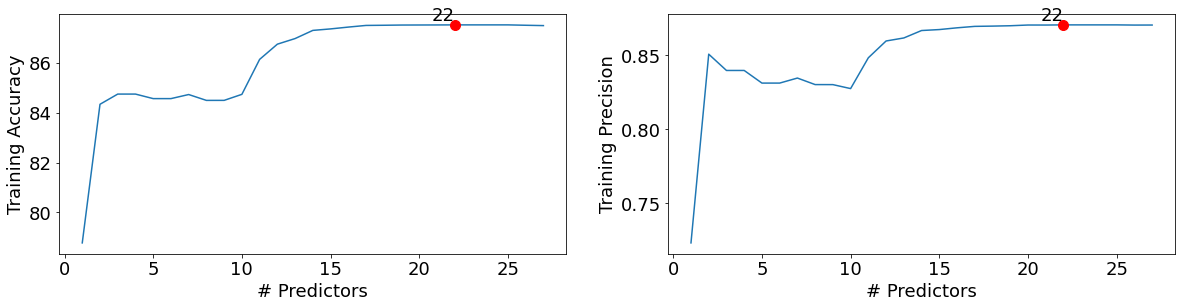

In [28]:
def precision(matrix):
    return matrix[0].loc['Actual 1', 'Predicted 1'] / (matrix[0].loc['Actual 1', 'Predicted 1'] + matrix[0].loc['Actual 0', 'Predicted 1'])

    


best_sub_plots(models_best)

In [35]:
# Determined by best minimum classification accuracy
best_fwd_reg_model = models_best['model'][22]
best_fwd_reg_model.summary()

pickle.dump(best_fwd_reg_model, open('forward_selection.sav', 'wb'))

In [36]:
cf_test = confusion_matrix(Xtest, ytest, best_fwd_reg_model, 0.9)
cm = cf_test[0]
precision = cm['Predicted 1']['Actual 1'] / (cm['Predicted 1']['Actual 0'] + cm['Predicted 1']['Actual 1'])

print(cf_test)
print("Precision:", precision)

(          Predicted 0  Predicted 1
Actual 0      14455.0         73.0
Actual 1       5582.0       5783.0, 78.16012049588691)
Precision: 0.9875341530054644


### Accuracy on Test: 78.16% {-}
### Precision on Test: 98.75% {-}

### Logistic Regression  {-}

In [69]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

In [56]:
parameters = {
    "penalty": ['l1', 'l2', 'elasticnet'],
    "C": np.geomspace(0.01, 100, 5),
    "solver": ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

cv = KFold(n_splits = 5, shuffle = True, random_state = 1)
model = GridSearchCV(
    LogisticRegression(random_state = 1),
    parameters,
    n_jobs = -1,
    verbose = 1,
    cv = cv
)

model.fit(X, y)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=LogisticRegression(random_state=1), n_jobs=-1,
             param_grid={'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             verbose=1)

In [57]:
model.best_params_

{'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}

In [92]:
model_updated = LogisticRegression(
    C = 0.01, penalty = 'l2', solver = 'newton-cg'
).fit(X, y)

pickle.dump(model_updated, open('logistic_regression.sav', 'wb'))
print(confusion_matrix_data(Xtest,ytest,model_updated,cutoff=0.7))

Accuracy =  86.27042057698992
Precision =  93.85669362084457
FNR =  26.467223933128025
FPR =  3.765143171806167
TPR or Recall =  73.53277606687197
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0      13981.0        547.0
Actual 1       3008.0       8357.0
 


### Accuracy on Test: 86.27% {-}
### Precision on Test: 93.86% {-}

## Non-Linear Models (303-3 Models) {-}

### Basic Decision Tree {-}

In [110]:
parameters = {
    'max_depth': [10, 25, 50],
    'max_leaf_nodes': [50, 100, 200]
}

cv = KFold(n_splits = 5, shuffle = True, random_state = 1)
model = GridSearchCV(
    DecisionTreeClassifier(random_state = 1),
    parameters,
    n_jobs = -1,
    verbose = 1,
    cv = cv
)

model.fit(X, y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [10, 25, 50],
                         'max_leaf_nodes': [50, 100, 200]},
             verbose=1)

In [111]:
model.best_params_

{'max_depth': 25, 'max_leaf_nodes': 200}

In [100]:
model_updated = DecisionTreeClassifier(
    max_depth = 25, max_leaf_nodes = 200, random_state = 1
).fit(X, y)

pickle.dump(model_updated, open('decision_tree_basic.sav', 'wb'))

cf_test = confusion_matrix(Xtest, ytest, model_updated, 0.9)
cm = cf_test[0]
accuracy = (cm['Predicted 0']['Actual 0'] + cm['Predicted 1']['Actual 1']) / (cm['Predicted 0'].sum() + cm['Predicted 1'].sum())
precision = cm['Predicted 1']['Actual 1'] / (cm['Predicted 1']['Actual 0'] + cm['Predicted 1']['Actual 1'])

print(cf_test)
print("Accuracy:", accuracy)
print("Precision:", precision)

(          Predicted 0  Predicted 1
Actual 0      14141.0        387.0
Actual 1        753.0      10612.0, 95.59726567025837)
Accuracy: 0.9559726567025837
Precision: 0.9648149831802891


### Accuracy on Test: 95.60% {-}
### Precision on Test: 96.48% {-}

In [43]:
pd.DataFrame(
    zip(X.columns, model_updated.feature_importances_),
    columns = ["feature", "importance"]
).sort_values(
    by = "importance",
    key = lambda x: abs(x),
    ascending = False
)

,feature,importance
7,Online_boarding,0.412583
2,Inflight_wifi_service,0.200737
23,Type_of_Travel_Personal_Travel,0.149791
9,Inflight_entertainment,0.051871
21,Customer_Type_disloyal_Customer,0.027791
13,Checkin_service,0.025959
24,Class_Business,0.023013
5,Gate_location,0.017915
22,Type_of_Travel_Business_travel,0.017412
20,Customer_Type_Loyal_Customer,0.016967


### Bagged Logistic Regression Model {-}

Currently trying 10 estimators
Currently trying 65 estimators
Currently trying 121 estimators
Currently trying 177 estimators
Currently trying 232 estimators
Currently trying 288 estimators
Currently trying 344 estimators
Currently trying 400 estimators


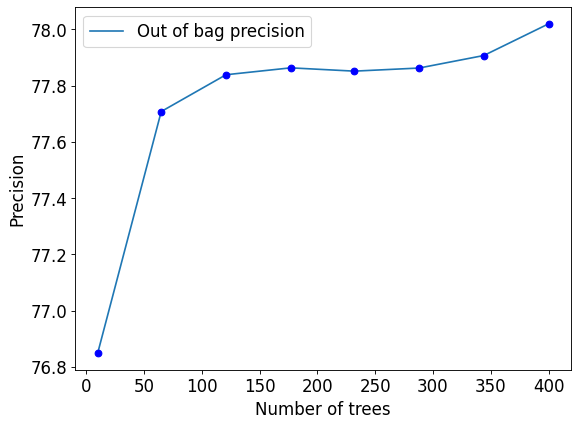

In [11]:
oob_precision = {}

for i in np.linspace(10, 400, 8, dtype = int):
    print(f"Currently trying {i} estimators")
    model = BaggingClassifier(
        base_estimator = LogisticRegression(),
        n_estimators = i, random_state = 1,
        n_jobs = -1, oob_score = True
    ).fit(X, y)
    
    oob_pred = model.oob_decision_function_[:,1]
    bins = np.array([0,0.5,1])
    cm = np.histogram2d(y, oob_pred, bins=bins)[0]
    oob_precision[i] = 100*(cm[1,1])/(cm[0,1]+cm[1,1])
    
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(oob_precision.keys(),oob_precision.values(),label = 'Out of bag precision')
plt.plot(oob_precision.keys(),oob_precision.values(),'o',color = 'blue')
plt.xlabel('Number of trees')
plt.ylabel('Precision')
plt.legend()

In [12]:
params = {
    'n_estimators': range(300, 650, 50)
}
param_list = list(it.product(*(params[name] for name in params)))
precision = [None for i in range(len(param_list))]

for index, pr in enumerate(param_list):
    print(f"Currently trying {pr[0]} estimators")
    model = BaggingClassifier(
        base_estimator = LogisticRegression(),
        n_estimators = pr[0], random_state = 1,
        n_jobs = -1, oob_score = True
    ).fit(X, y)
    
    oob_pred = model.oob_decision_function_[:,1]
    bins = np.array([0,0.5,1])
    cm = np.histogram2d(y, oob_pred, bins=bins)[0]
    precision[index] = 100*(cm[1,1])/(cm[0,1]+cm[1,1])

print("-----------------------")
print("max precision = ", np.max(precision))
print("params= ", param_list[np.argmax(precision)])

Currently trying 300 estimators
Currently trying 350 estimators
Currently trying 400 estimators
Currently trying 450 estimators
Currently trying 500 estimators
Currently trying 550 estimators
Currently trying 600 estimators
-----------------------
max precision =  78.12116856212742
params=  (500,)


In [80]:
model_updated = BaggingClassifier(
    base_estimator = LogisticRegression(),
    n_estimators = 500, random_state = 1,
    n_jobs = -1, oob_score = True
).fit(X, y)

In [79]:
pickle.dump(model_updated, open('bagging_logistic_regression.sav', 'wb'))

In [74]:
print(confusion_matrix_data(Xtest,ytest,model_updated,cutoff=0.75))

Accuracy =  78.04812111381455
Precision =  90.06912117364932
FNR =  43.81874175098988
FPR =  4.845814977973569
TPR or Recall =  56.18125824901012
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0      13824.0        704.0
Actual 1       4980.0       6385.0
 


### Accuracy on Test: 78.05% {-}
### Precision on Test: 90.07% {-}

### Bagged Decision Tree Model {-}

Currently trying 10 estimators
Currently trying 65 estimators
Currently trying 121 estimators
Currently trying 177 estimators
Currently trying 232 estimators
Currently trying 288 estimators
Currently trying 344 estimators
Currently trying 400 estimators


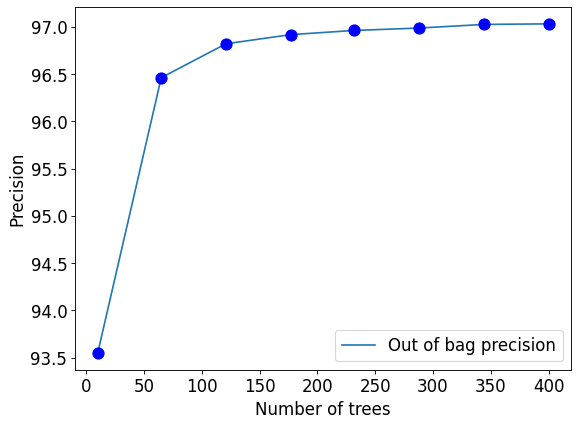

In [98]:
oob_precision = {}

for i in np.linspace(10, 400, 8, dtype = int):
    print(f"Currently trying {i} estimators")
    model = BaggingClassifier(
        base_estimator = DecisionTreeClassifier(),
        n_estimators = i, random_state = 1,
        n_jobs = -1, oob_score = True
    ).fit(X, y)
    
    oob_pred = model.oob_decision_function_[:,1]
    bins = np.array([0,0.5,1])
    cm = np.histogram2d(y, oob_pred, bins=bins)[0]
    oob_precision[i] = 100*(cm[1,1])/(cm[0,1]+cm[1,1])
    
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(oob_precision.keys(),oob_precision.values(),label = 'Out of bag precision')
plt.plot(oob_precision.keys(),oob_precision.values(),'o',color = 'blue')
plt.xlabel('Number of trees')
plt.ylabel('Precision')
plt.legend()

In [102]:
params = {
    'n_estimators': range(200, 425, 25)
}
param_list = list(it.product(*(params[name] for name in params)))
precision = [None for i in range(len(param_list))]

for index, pr in enumerate(param_list):
    print(f"Currently trying {pr[0]} estimators")
    model = BaggingClassifier(
        base_estimator = DecisionTreeClassifier(),
        n_estimators = pr[0], random_state = 1,
        n_jobs = -1, oob_score = True
    ).fit(X, y)
    
    oob_pred = model.oob_decision_function_[:,1]
    bins = np.array([0,0.5,1])
    cm = np.histogram2d(y, oob_pred, bins=bins)[0]
    precision[index] = 100*(cm[1,1])/(cm[0,1]+cm[1,1])

print("-----------------------")
print("max precision = ", np.max(precision))
print("params= ", param_list[np.argmax(precision)])

Currently trying 200 estimators
Currently trying 225 estimators
Currently trying 250 estimators
Currently trying 275 estimators
Currently trying 300 estimators
Currently trying 325 estimators
Currently trying 350 estimators
Currently trying 375 estimators
Currently trying 400 estimators
-----------------------
max precision =  97.0374280010097
params=  (350,)


In [101]:
model_updated = BaggingClassifier(
    base_estimator = DecisionTreeClassifier(),
    n_estimators = 350, random_state = 1,
    n_jobs = -1, oob_score = True
).fit(X, y)

pickle.dump(model_updated, open('bagging_decision_tree.sav', 'wb'))

In [102]:
print(confusion_matrix_data(Xtest,ytest,model_updated,cutoff=0.9))

Accuracy =  94.624029660526
Precision =  99.67128200019923
FNR =  11.957765068191817
FPR =  0.22714757709251102
TPR or Recall =  88.04223493180818
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0      14495.0         33.0
Actual 1       1359.0      10006.0
 


### Accuracy on Test: 94.62% {-}
### Precision on Test: 99.67% {-}

In [48]:
feature_importances = np.mean([
    tree.feature_importances_ for tree in model_updated.estimators_
], axis=0)

pd.DataFrame(
    zip(X.columns, feature_importances),
    columns = ["feature", "importance"]
).sort_values(
    by = "importance",
    key = lambda x: abs(x),
    ascending = False
)

,feature,importance
7,Online_boarding,0.362442
2,Inflight_wifi_service,0.177195
22,Type_of_Travel_Business_travel,0.075931
23,Type_of_Travel_Personal_Travel,0.070897
9,Inflight_entertainment,0.047534
13,Checkin_service,0.028298
1,Flight_Distance,0.024670
0,Age,0.022664
21,Customer_Type_disloyal_Customer,0.020128
20,Customer_Type_Loyal_Customer,0.019852


### Random Forest {-}

In [75]:
#Finding model accuracy vs number of trees
oob_accuracy={};test_accuracy={};oob_precision={}; test_precision = {}

for i in np.linspace(50,500,45,dtype=int):
    model = RandomForestClassifier(n_estimators=i,
                                   random_state=1,max_features="sqrt",n_jobs=-1,oob_score=True).fit(X, y)
    oob_accuracy[i]=model.oob_score_ #Returns the out-of_bag R-squared of the model
    test_accuracy[i]=model.score(Xtest,ytest) #Returns the test R-squared of the model
    oob_pred = model.oob_decision_function_[:,1]
    bins=np.array([0,0.5,1])
    cm = np.histogram2d(y, oob_pred, bins=bins)[0]
    oob_precision[i] = 100*(cm[1,1])/(cm[0,1]+cm[1,1])
    test_pred = model.predict_proba(Xtest)[:,1]
    cm = np.histogram2d(ytest, test_pred, bins=bins)[0]
    test_precision[i] = 100*(cm[1,1])/(cm[0,1]+cm[1,1])

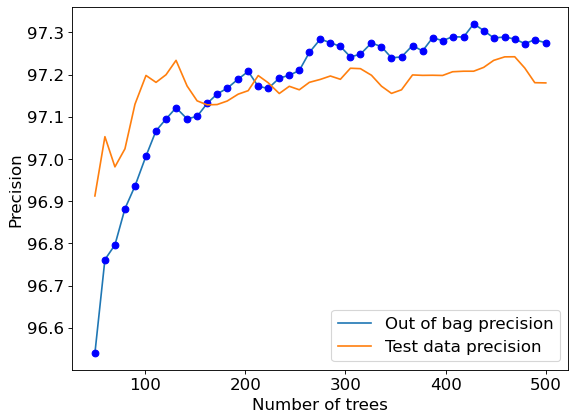

In [76]:
#Precision vs number of trees
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(oob_precision.keys(),oob_precision.values(),label = 'Out of bag precision')
plt.plot(oob_precision.keys(),oob_precision.values(),'o',color = 'blue')
plt.plot(test_precision.keys(),test_precision.values(), label = 'Test data precision')
plt.xlabel('Number of trees')
plt.ylabel('Precision')
plt.legend()

In [89]:
params = {'n_estimators': [400, 450, 500],
          'max_features': range(2,28)
         }

param_list=list(it.product(*(params[Name] for Name in list(params.keys()))))
precision = [0]*len(param_list)

len(precision)

78

In [90]:
i=0

for pr in param_list:
    print(i)
    model = RandomForestClassifier(random_state=1,
                                   oob_score=True,
                                   verbose=False,
                                   n_estimators= pr[0],
                                   max_features=pr[1], n_jobs=-1).fit(X,y)
    oob_pred = model.oob_decision_function_[:,1]
    bins=np.array([0,0.5,1])
    cm = np.histogram2d(y, oob_pred, bins=bins)[0]
    precision[i] = 100*(cm[1,1])/(cm[0,1]+cm[1,1])
    i=i+1

print("max precision = ", np.max(precision))
print("params= ", param_list[np.argmax(precision)])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
max recall =  97.47164515609543
params=  (450, 13)


In [103]:
model = RandomForestClassifier(random_state=1,n_jobs=-1,max_features=13,n_estimators=450).fit(X, y)
pickle.dump(model, open('random_forest.sav', 'wb'))

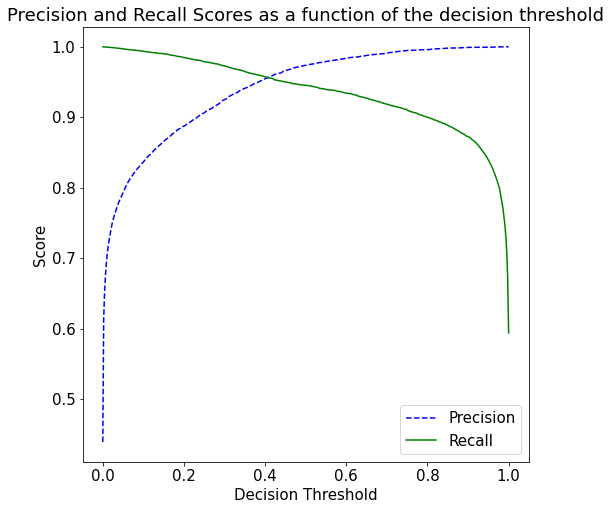

In [96]:
ypred = model.predict_proba(Xtest)[:, 1]
p, r, thresholds = precision_recall_curve(ytest, ypred)
plot_precision_recall_vs_threshold(p, r, thresholds)

In [104]:
# print(confusion_matrix_data(X,y,model,cutoff=0.9))
print(confusion_matrix_data(Xtest,ytest,model,cutoff=0.9))

Accuracy =  94.35754837214691
Precision =  99.89923417976622
FNR =  12.767267927848659
FPR =  0.06883259911894272
TPR or Recall =  87.23273207215134
Confusion matrix = 
           Predicted 0  Predicted 1
Actual 0      14518.0         10.0
Actual 1       1451.0       9914.0
 


### Accuracy on Test: 94.36% {-}
### Precision on Test: 99.90% {-}

In [50]:
pd.DataFrame(
    zip(X.columns, model.feature_importances_),
    columns = ["feature", "importance"]
).sort_values(
    by = "importance",
    key = lambda x: abs(x),
    ascending = False
)

,feature,importance
7,Online_boarding,0.254339
2,Inflight_wifi_service,0.165130
24,Class_Business,0.083853
22,Type_of_Travel_Business_travel,0.054746
23,Type_of_Travel_Personal_Travel,0.050953
9,Inflight_entertainment,0.049428
25,Class_Eco,0.029262
8,Seat_comfort,0.027693
0,Age,0.025448
4,Ease_of_Online_booking,0.025273


# Summary of Model Performances (on Test Set) {-}

* Format is {Model Name}: {Accuracy}, {Precision}

* Forward Selection: 78.07, 98.97
* Logistic Regression: 86.27, 93.86
* Decision Tree: 95.60, 96.48
* Bagging (Logistic Regression): 78.05, 90.07
* Bagging (Decision Tree): 94.62, 99.67
* Random Forest: 94.36, 99.90